# Grant: Per-probe parameter editing + post-run plot/GUI reload

Use this notebook to:
1. edit `grant_recording_config.json` per-probe/per-mode overrides from notebook cells,
2. resolve `ks_dir` and `save_path` for any run mode + probe,
3. reload and rerun:
   - `bc.plot_summary_data(...)` (correct spelling; not `plot_sumary_data`)
   - `bc.compare_manual_vs_bombcell(save_path)`
   - `bc.unit_quality_gui(...)` (main interactive GUI).


In [1]:
from pathlib import Path
import json
import copy

import bombcell as bc

CONFIG_FILE = Path(r'C:\Users\user\Documents\github\bombcell\py_bombcell\grant\configs\grant_recording_config_reach15_20260201_session007.json')
RUN_MODE = 'batch'  # batch | single_probe | np20_rerun
TARGET_PROBE = 'B'  # A-F
SAVE_CONFIG = False  # set True only when you want to write config updates


✅ ipywidgets available - interactive GUI ready


In [2]:
import sys
from pathlib import Path
sys.path.insert(0, str((Path.cwd() / '..' / '..').resolve()))

from grant.grant_config import load_grant_config

cfg = load_grant_config(CONFIG_FILE)
print('Loaded config:', cfg['config_path'])
print('Recording:', cfg['recording_name'])
print('Target probe:', TARGET_PROBE)
print('Run mode:', RUN_MODE)


Loaded config: C:\Users\user\Documents\github\bombcell\py_bombcell\grant\configs\grant_recording_config_reach15_20260201_session007.json
Recording: Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00
Target probe: B
Run mode: batch


## 1) Edit per-probe/per-mode overrides inside notebook

- `probe_param_overrides[probe]['all_modes']` applies to every mode for that probe.
- `probe_param_overrides[probe]['modes'][mode]` applies only for one mode.
- Set `SAVE_CONFIG=True` to persist changes back to JSON.


In [3]:
raw = json.loads(CONFIG_FILE.read_text(encoding='utf-8'))
probe_cfg = raw.setdefault('probe_param_overrides', {}).setdefault(TARGET_PROBE, {})
all_modes = probe_cfg.setdefault('all_modes', {})
modes = probe_cfg.setdefault('modes', {})
this_mode = modes.setdefault(RUN_MODE, {})

# ---- Example edits (change values as needed) ----
all_modes['minPresenceRatio'] = all_modes.get('minPresenceRatio', 0.7)
this_mode['maxRPVviolations'] = this_mode.get('maxRPVviolations', 0.2)

print('all_modes overrides for probe', TARGET_PROBE, ':', all_modes)
print(f"mode-specific overrides for probe {TARGET_PROBE} / {RUN_MODE}:", this_mode)

if SAVE_CONFIG:
    CONFIG_FILE.write_text(json.dumps(raw, indent=2), encoding='utf-8')
    print('Saved updated config to', CONFIG_FILE)
else:
    print('SAVE_CONFIG=False -> no file written')


all_modes overrides for probe B : {'maxRPVviolations': 0.2, 'minPresenceRatio': 0.6, 'presenceRatioBinSize': 120, 'tauR_valuesMin': 0.0005, 'tauR_valuesMax': 0.002, 'tauR_valuesStep': 0.0005, 'computeTimeChunks': True, 'deltaTimeChunk': 360}
mode-specific overrides for probe B / batch: {'maxRPVviolations': 0.2}
SAVE_CONFIG=False -> no file written


## 2) Resolve run paths for this mode/probe

The unified runner stages outputs to:
- `.../kilosort4_{probe}/bombcell/DEFAULT` for `batch`
- `.../kilosort4_{probe}/bombcell/NP2_RERUN` for `np20_rerun`
- `.../kilosort4_{probe}/bombcell/SINGLE_PROBE` for `single_probe`


In [6]:
mode_to_roots = {
    'batch': (cfg['default_ks_staging_root'], ''),
    'np20_rerun': (cfg['np20_ks_staging_root'], ''),
    'single_probe': (cfg['bombcell_singleprobe_root'], ''),
}

staging_root, save_subdir = mode_to_roots[RUN_MODE]
ks_dir = Path(staging_root) / f'kilosort4_{TARGET_PROBE}'
save_path = ks_dir / 'bombcell' / save_subdir

print('ks_dir:', ks_dir)
print('save_path:', save_path)
print('ks_dir exists:', ks_dir.exists())
print('save_path exists:', save_path.exists())


ks_dir: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\kilosort4_B
save_path: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\kilosort4_B\bombcell
ks_dir exists: True
save_path exists: True


## 3) Reload everything needed for summary plots + GUI


In [8]:
# Reload parameter + quality metrics from saved bombcell outputs
param, quality_metrics, _ = bc.load_bc_results(str(save_path))

# Reload template waveforms from staged kilosort directory
_, _, template_waveforms, _, _, _, _ = bc.load_ephys_data(str(ks_dir))

# Recompute unit type labels from loaded outputs
unit_type, unit_type_string = bc.qm.get_quality_unit_type(param, quality_metrics)

print('n units:', len(unit_type))
print('template_waveforms shape:', getattr(template_waveforms, 'shape', None))


n units: 1316
template_waveforms shape: (1318, 61, 383)


## 4) Rerun summary plots for any probe after any Bombcell run


c:\Users\user\anaconda3\envs\bombcell\Lib\site-packages\upsetplot\plotting.py:795: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  styles["linewidth"].fillna(1, inplace=True)
c:\Users\user\anaconda3\envs\bombcell\Lib\site-packages\upsetplot\plotting.py:796: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series

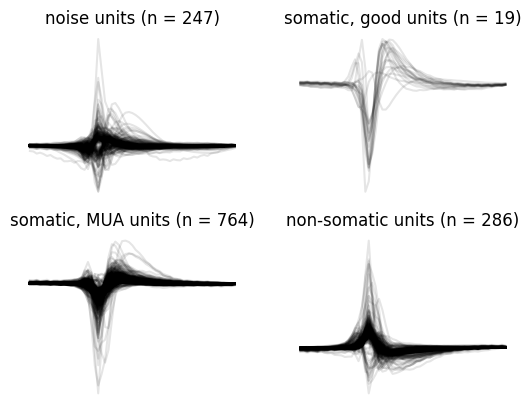

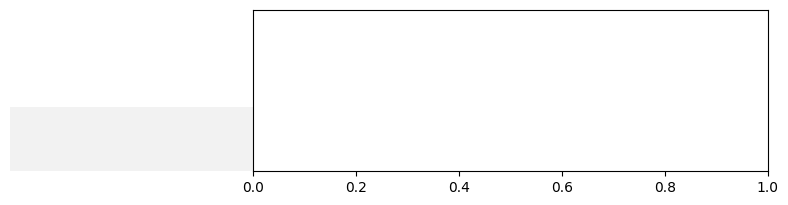

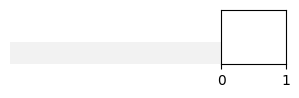

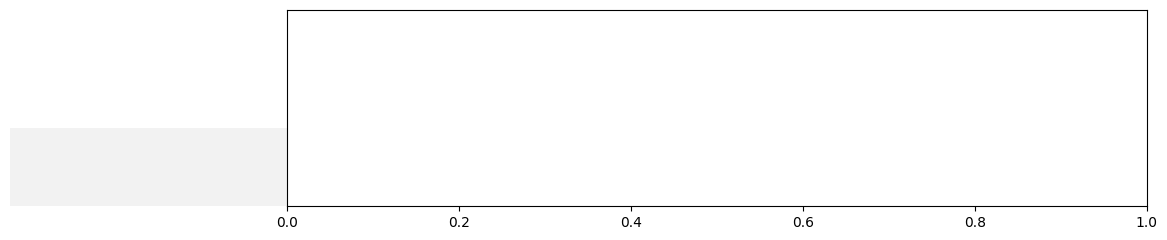

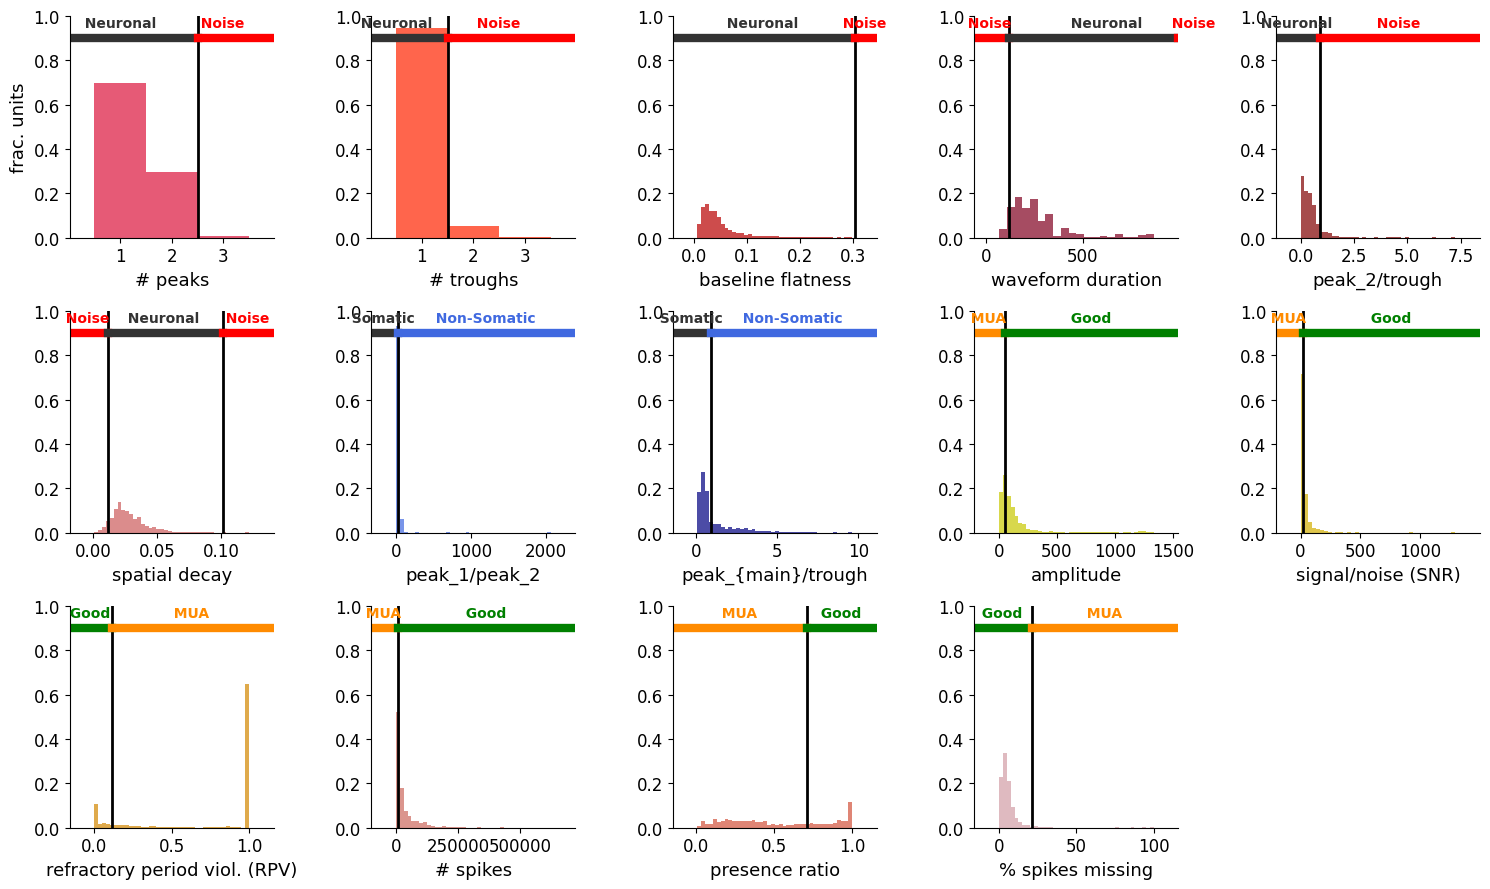

In [9]:
# Correct API call name: plot_summary_data
bc.plot_summary_data(quality_metrics, template_waveforms, unit_type, unit_type_string, param)


## 5) Reload manual-vs-bombcell comparison


In [10]:
bc.compare_manual_vs_bombcell(str(save_path))


📊 Comparing manual vs BombCell classifications from: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\kilosort4_B\bombcell
✅ Loaded BombCell results: 1316 units
❌ No manual classifications found. Please use the GUI to manually classify some units first.
Expected file: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_DEFAULT\kilosort4_B\bombcell\manual_unit_classifications.csv
❌ No manual classifications found.
   Use the GUI to manually classify some units first:
   bc.unit_quality_gui(ks_dir, quality_metrics, unit_types, param, save_path)


## 6) Launch main/master Bombcell GUI for this run


In [ ]:
gui = bc.unit_quality_gui(
    ks_dir=str(ks_dir),
    quality_metrics=quality_metrics,
    unit_types=unit_type,
    param=param,
    save_path=str(save_path),
)
gui


Loaded GUI data from: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_single_probe\kilosort4_B\bombcell\SINGLE_PROBE\for_GUI\gui_data.pkl
🚀 Auto-loaded GUI data from: H:\Grant\Neuropixels\Kilosort_Recordings\Reach15_20260201_session007_NP_Recording_Number02_2026-02-01_18-25-00\bombcell\bombcell_single_probe\kilosort4_B\bombcell\SINGLE_PROBE\for_GUI\gui_data.pkl
GUI data loaded successfully!
   Data types available: ['peak_locations', 'trough_locations', 'peak_loc_for_duration', 'trough_loc_for_duration', 'peak_trough_labels', 'duration_lines', 'spatial_decay_fits', 'amplitude_fits', 'channel_arrangements', 'waveform_scaling', 'acg_data', 'per_bin_metrics']
   Peak/trough detection: 1313 units
   Spatial decay fits: 1313 units
   Amplitude fits: 1311 units
Total units: 1318
📝 Initialized manual classification system (no previous classifications found)
🚀 Auto-advance enabled: will automatically go to next un